<a href="https://colab.research.google.com/github/srrajesh113/Diabetes-Prediction-Software-Using-Python/blob/main/human_activity_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Activity Recognition

The videos are present in a directory called `'Data'`. I have used the `load_files()` function available in scikit-learn to get the absolute paths of these videos and their respective class labels. These paths will be later used to read the videos in the required format.

For detailed information on `load_files()`, read the documantation [here](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_files.html)

The whole data in randomly split into training and test data, with **test data being one-third of the total data**.
Also, approximately **25% of the training data will be used as the _validation set_**.

In [26]:
from google.colab import drive
drive.mount('/content/drive')
#4/1AY0e-g5feD1TY0KncNLo0E2QOWtRiNNedACanFdcOtgPYa2mGtOmKL6KJe4

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# Imports
import os
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split

# Loading the data
raw_data = load_files('//content/drive/MyDrive/Learn/data1', shuffle=False)
files = raw_data['filenames']
targets = raw_data['target']
print("1")
# Randomly dividing the whole data into training (66.67%) and testing (33.33%) data 
train_files, test_files, train_targets, test_targets = train_test_split(files, targets, test_size=1/3, random_state=191)

# Taking ~25% of the training data for validation
valid_files = train_files[150:]
valid_targets = train_targets[150:]

# Remaining data will be used for training the model
train_files = train_files[:150]
train_targets = train_targets[:150]

test_files = test_files[:]
test_targets = test_targets[:]

# Generic details about the data
print('Total number of videos:', len(files))
print('\nNumber of videos in training data:', train_files.shape[0])
print('Number of videos in validation data:', valid_files.shape[0])
print('Number of videos in test data:', test_files.shape[0])

1
Total number of videos: 299

Number of videos in training data: 150
Number of videos in validation data: 49
Number of videos in test data: 100


### Description of the class labels

In [29]:
print('The categorical labels are converted into integers.\nFollowing is the mapping - \n')
for label in zip(range(6), raw_data['target_names']):
    print(label)

The categorical labels are converted into integers.
Following is the mapping - 

(0, 'boxing')
(1, 'handwaving')
(2, 'running')


### Each video file is associated with its class label

In [30]:
# Displaying the first 5 videos (paths) in the training data along with their labels
# (path of video, class label)
for pair in zip(train_files[:5], train_targets[:5]):
    print(pair)

('//content/drive/MyDrive/Learn/data1/handwaving/person15_handwaving_d1_uncomp.avi', 1)
('//content/drive/MyDrive/Learn/data1/running/person09_running_d1_uncomp.avi', 2)
('//content/drive/MyDrive/Learn/data1/handwaving/person17_handwaving_d1_uncomp.avi', 1)
('//content/drive/MyDrive/Learn/data1/running/person21_running_d3_uncomp.avi', 2)
('//content/drive/MyDrive/Learn/data1/handwaving/person01_handwaving_d4_uncomp.avi', 1)


## Exploring the video dataset

There is a helper class called `Videos` in `utils.py` for reading the videos into *numpy ndarrays*.

The class provides some additional functionalities like:

- Setting the target size for each frame of a video
- Conversion each frame to gray scale
- Various options to extract a subset of frames from each video
- Normalizing the pixel values of each video

We will use this to load out training, validation and test data.

### Let's load a sample of the training data *as it is*.

In [31]:
!pip install sk-video


100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


Shape of the sample data: (1, 581, 120, 160, 1)


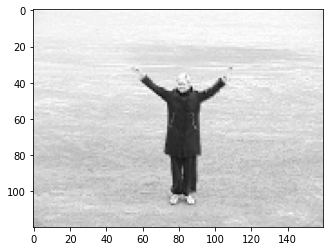

In [32]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from utils import Videos
%matplotlib inline


# The path of a sample video in the training data
sample_files = train_files[:1]

# An object of the class 'Videos'
reader = Videos(target_size=None, 
                to_gray=True)

# Loading the sample videos, in their original format
sample = reader.read_videos(sample_files)
print('\nShape of the sample data:', sample.shape)

# Displaying a frame from the sample video
#plt.imshow(sample[0][150])
plt.imshow(np.squeeze(sample[0][300], axis=2), cmap='gray')

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The shape of the tensor obtained is **(1, 515, 120, 160, 3)**.

This indicates that:

- There is **1 video**.
- The video has **515 frames**.
- The dimension of **each frame is 120x160 pixels**.
- There are **3 channels** for each frame - Red(R), Green(G) and Blue(B)

---

## Pre-processing the Data

### Conversion of frames to gray scale
In order to simplify the computations and complexity of our models, the *frames could be converted to gray scale*. Also, since we intend the model to learn the movement patterns of the human subjects, the *color aspect of the video would not matter*.

### Frame Extraction
The dataset contains **video of varying length**. This means that the number of frames in each video is not the same. *In order to stack the videos in a tensor, each video should have the same number of frames*. Therefore, we would have to select the same number of frames from each video.

Now, when it comes to frame selection, there can be several techniques.

Suppose we want 'N' frames (N/25 seconds) for each video. *These frames should be contiguous* (i.e., the frames should not be selected randomly) so that our model can detect the patterns successfully. 

We can follow one of the 3 obvious strategies:
1. Extract the **first N frames** from each video
2. Extract the **last N frames** from each video
3. Extract **N frames from the middle**.  
    Let's say that the video has 'M' frames in total. If we select N frames, there are (M - N) frames left.
    In order to do frame selection from the middle of the video, we would *remove the first (M - N)/2 frames* and the *last (M - N)/2 frames*.
    
### Dimensions of each frame in a video
We might have a situation where the *spatial dimensions (width and height) of the frames could be different in different videos*. In such a case, our model would fail to function properly. Therefore, we would require *each frame in every video to have the same spatial dimension*.

Fortunately, in our dataset, every video has the spatial dimension of 120x160 pixels. But, I will still resize each video to have a spatial dimension of 128x128 pixels

### Pixel Normalization
Data normalization is an important step which ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network.

The pixel value ranges from 0 to 255. So, we will bring it in the range [0, 1].

** The helper function `read_videos()` that we used before provides the functionality to do all of these _customizations_.**

### One-hot Encoding
**Categorical labels** should be encoded using this technique called *One-hot Encoding*.

Example-

*Before One-hot encoding*

| Class Label | Mapped Integer |
| :---------: | :------------: |
| Boxing | 0 |
| Handclapping | 1 |
| Handwaving | 2 |
| Jogging | 3 |
| Running | 4 |
| Walking | 5 |

*After One-hot encoding*

| Class Label | 0 | 1 | 2 | 3 | 4 | 5 |
| :---------: | - | - | - | - | - | - |
| Boxing | 1 | 0 | 0 | 0 | 0 | 0 |
| Handclapping | 0 | 1 | 0 | 0 | 0 | 0 |
| Handwaving | 0 | 0 | 1 | 0 | 0 | 0 |
| Jogging | 0 | 0 | 0 | 1 | 0 | 0 |
| Running | 0 | 0 | 0 | 0 | 1 | 0 |
| Walking | 0 | 0 | 0 | 0 | 0 | 1 |

We will use the `to_categorical()` functions provided by the `keras.utils` module for one-hot encoding the labels.  
For further details, read the documentation [here](https://keras.io/utils/#to_categorical)

---

We will now load the data where:

- Each video will have a spatial dimension of 128x128 pixels
- Each video will have a maximum of 200 frames (extracted from the middle)
- The pixels will be normalized to the range [0, 1]
- The class labels are One-hot Encoded

In [ ]:
# Imports
import numpy as np
from keras.utils import to_categorical
from utils import Videos

# An object of the class `Videos` to load the data in the required format
reader = Videos(target_size=(128, 128), 
                to_gray=True, 
                max_frames=150, 
                extract_frames='middle', 
                normalize_pixels=(0, 1))

In [ ]:
# Reading training videos and one-hot encoding the training labels
X_train = reader.read_videos(train_files)
y_train = to_categorical(train_targets, num_classes=6)
print('Shape of training data:', X_train.shape)
print('Shape of training labels:', y_train.shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [02:52<00:00,  2.03s/it]


Shape of training data: (85, 150, 128, 128, 1)
Shape of training labels: (85, 6)


In [ ]:
y_train[:5]

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [ ]:
# Reading validation videos and one-hot encoding the validation labels
X_valid = reader.read_videos(valid_files)
y_valid = to_categorical(valid_targets, num_classes=6)
print('Shape of validation data:', X_valid.shape)
print('Shape of validation labels:', y_valid.shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [01:07<00:00,  1.61s/it]


Shape of validation data: (42, 150, 128, 128, 1)
Shape of validation labels: (42, 6)


In [ ]:
# Reading testing videos and one-hot encoding the testing labels
X_test = reader.read_videos(test_files)
y_test = to_categorical(test_targets, num_classes=6)
print('Shape of testing data:', X_test.shape)
print('Shape of testing labels:', y_test.shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [01:48<00:00,  1.69s/it]


Shape of testing data: (64, 150, 128, 128, 1)
Shape of testing labels: (64, 6)


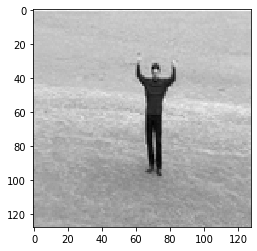

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# After pre-processing

# Displaying the first frame of the first processed video from the training data
plt.imshow(np.squeeze(X_train[1][100], axis=2), cmap='gray')

The shape of the training data is **(300, 200, 128, 128, 1)**

This indicates that - 

- There are **300 videos**.
- The video has **exactly 200 frames**.
- The dimension of **each frame is 128x128 pixels**.
- There is **only 1 channel** for each frame, i.e., all videos are gray scale

---

## Model Construction

### Model - 1

A simple convolutional model is now constructed for the data that we have. The model has **alternating convolutional and pooling layers**. THe advantage of such a model is that it can be used to *encode the content of the image into a vector (with more depth, but less height and width)*. What this means is that the convolutional layers will be used to make the input deeper (increase the depth of the image - producing a stack of multiple feature maps), whereas the pooling layers will reduce the spatial dimensions of the input.

For each convolutional layer, we have to configure the following parameters:

- `filters`: This is the number of feature maps required as the output of that convolutional layer. 
- `kernel_size`: The size of the window that will get convolved along all thhe axes of the input data to produce a single feature map.
- `strides`: The number of pixels by which the convolutional window should shift by.
- `padding`: To decide what happens on the edges - either the input gets cropped (`valid`) or the input is padded with zeros to maintain the same dimensionality (`same`).
- `activation`: The activation function to be used for that layer. (`ReLU` is proven to work best with deep neural networks because of its *non-linearity*, and it property of *avoiding the vanishing gradient problem*).

I have used the **MaxPooling Layer** that takes the maximum value of the input in the specified window.

For each pooling layer, we have to configure the following parameters:

- `pool_size`: The size of the window (from which to take the maximum value)
- `strides`: The number of pixels by which the pooling window should shift by.
- `padding`: To decide what happens on the edges - either the input gets cropped (`valid`) or the input is padded with zeros to maintain the same dimensionality (`same`).

Thses combination of alternating convolutional and pooling layers is followed by a Global Pooling layer. When there is no more spatial information left in the input to extract (the spatial dimensions of the input have cannot be further decreased by the pooling layers), the *Global pooling layer converts its input to a 1-d vector (having the same depth)*.

This **1-dimensional vector is then used as the input for a dense, fully-connected neural network**. The fully-connected network will have some hidden layers and an output layer (with 6 neurons - one for each class label). *For the output layer, I have used the softmax activation function*, that gives a probability for the input to belong to each of the class. Finally, the class label with the highest probability is assigned to that input.

For further information, read the documentation of on how to implement this model in Keras.

- [Convolutional Layer (3D)](https://keras.io/layers/convolutional/#conv3d)
- [MaxPooling Layer (3D)](https://keras.io/layers/pooling/#maxpooling3d)
- [GlobalAveragePooling Layer (3D)](https://keras.io/layers/pooling/#globalaveragepooling3d) - As of December 17, 2017 the official documentation of does not contain this layer. But this link should work fine once the documentation is updated.
- [Dense Layer](https://keras.io/layers/core/#dense)

In [ ]:
# Imports
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D
from keras.layers.core import Dense

# Using the Sequential Model
model = Sequential()

# Adding Alternate convolutional and pooling layers
model.add(Conv3D(filters=16, kernel_size=(10, 3, 3), strides=(5, 1, 1), padding='same', activation='relu', 
                 input_shape=X_train.shape[1:]))
model.add(MaxPooling3D(pool_size=2, strides=(1, 2, 2), padding='same'))

model.add(Conv3D(filters=64, kernel_size=(5, 3, 3), strides=(3, 1, 1), padding='valid', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=(1, 2, 2), padding='same'))

model.add(Conv3D(filters=256, kernel_size=(5, 3, 3), strides=(3, 1, 1), padding='valid', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=(1, 2, 2), padding='same'))

# A global average pooling layer to get a 1-d vector
# The vector will have a depth (same as number of elements in the vector) of 256
model.add(GlobalAveragePooling3D())

# The Global average pooling layer is followed by a fully-connected neural network, with one hidden and one output layer

# Hidden Layer
model.add(Dense(32, activation='relu'))

# Output layer
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 30, 128, 128, 16)  1456      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 30, 64, 64, 16)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 9, 62, 62, 64)     46144     
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 9, 31, 31, 64)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 2, 29, 29, 256)    737536    
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 2, 15, 15, 256)    0         
_________________________________________________________________
global_average_pooling3d_1 ( (None, 256)              

### Training Model - 1

Here, the model (`Model-1`) is being trained on the training data. For each *epoch* (iteration), the model is being validated using the validation data. The model is trained for 40 epochs. Also, the model (model's weights) that performed the best on the validation set is being saved in a file (`Model_1.weights.best.hdf5`).

### Evaluating Model - 1

The best model weights are loaded and then the model is evaluated on the test data. I have used accuracy as the metric to test the model's performance on the test data.

In [ ]:
# Imports
from keras.callbacks import ModelCheckpoint

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Saving the model that performed the best on the validation set
checkpoint = ModelCheckpoint(filepath='Model_1.weights.best.hdf5', save_best_only=True, verbose=1)

# Training the model for 40 epochs
history = model.fit(X_train, y_train, batch_size=16, epochs=3, 
                    validation_data=(X_valid, y_valid), verbose=2, callbacks=[checkpoint])

Epoch 1/3

Epoch 00001: val_loss improved from inf to 1.83541, saving model to Model_1.weights.best.hdf5
6/6 - 488s - loss: 1.8100 - accuracy: 0.1529 - val_loss: 1.8354 - val_accuracy: 0.0952
Epoch 2/3

Epoch 00002: val_loss did not improve from 1.83541
6/6 - 634s - loss: 1.7824 - accuracy: 0.2588 - val_loss: 1.8863 - val_accuracy: 0.0952
Epoch 3/3


In [ ]:
# Training the model for 40 epochs
history = model.fit(X_train, y_train, batch_size=16, epochs=3, 
                    validation_data=(X_valid, y_valid), verbose=2, callbacks=[checkpoint])

Epoch 1/3

Epoch 00001: val_loss improved from 1.80676 to 1.74429, saving model to Model_1.weights.best.hdf5
6/6 - 158s - loss: 1.6779 - accuracy: 0.2588 - val_loss: 1.7443 - val_accuracy: 0.0952
Epoch 2/3

Epoch 00002: val_loss improved from 1.74429 to 1.67054, saving model to Model_1.weights.best.hdf5
6/6 - 242s - loss: 1.5799 - accuracy: 0.2588 - val_loss: 1.6705 - val_accuracy: 0.0952
Epoch 3/3

Epoch 00003: val_loss improved from 1.67054 to 1.61683, saving model to Model_1.weights.best.hdf5
6/6 - 240s - loss: 1.4865 - accuracy: 0.2941 - val_loss: 1.6168 - val_accuracy: 0.2857


In [ ]:
# Training the model for 40 epochs
history = model.fit(X_train, y_train, batch_size=16, epochs=3, 
                    validation_data=(X_valid, y_valid), verbose=2, callbacks=[checkpoint])

Epoch 1/3

Epoch 00001: val_loss improved from 1.61683 to 1.53567, saving model to Model_1.weights.best.hdf5
6/6 - 191s - loss: 1.4285 - accuracy: 0.3882 - val_loss: 1.5357 - val_accuracy: 0.2857
Epoch 2/3

Epoch 00002: val_loss improved from 1.53567 to 1.33378, saving model to Model_1.weights.best.hdf5
6/6 - 190s - loss: 1.3316 - accuracy: 0.4471 - val_loss: 1.3338 - val_accuracy: 0.3571
Epoch 3/3

Epoch 00003: val_loss improved from 1.33378 to 1.23422, saving model to Model_1.weights.best.hdf5
6/6 - 170s - loss: 1.2912 - accuracy: 0.2471 - val_loss: 1.2342 - val_accuracy: 0.3571


In [ ]:
# Loading the model that performed the best on the validation set
model.load_weights('Model_1.weights.best.hdf5')

# Testing the model on the Test data
(loss, accuracy) = model.evaluate(X_test, y_test, batch_size=16, verbose=0)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))

Accuracy on test data: 25.00%


## Model - 1 Performance

The model gave an **Accuracy of 37% on the test data**.

### Learning Curve - Training loss vs. Validation loss

Used to determine whether the *model is overfitting to the training data* or not. If yes, then which *model performed the best on the validation set is chosen*.

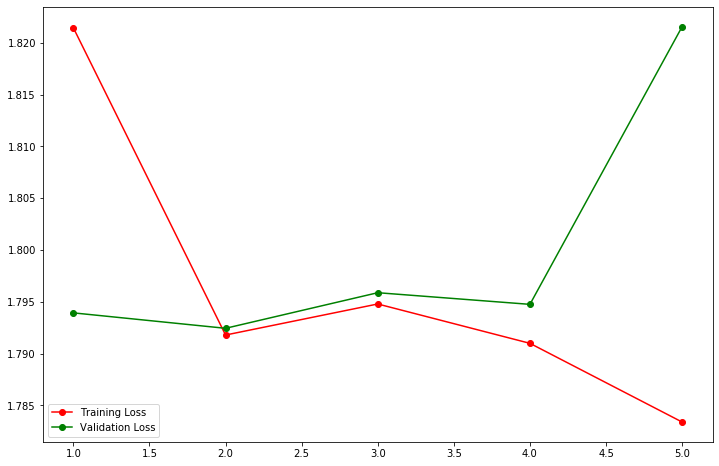

In [ ]:
# Making the plot larger
plt.figure(figsize=(12, 8))

loss = history.history['loss']                          # Loss on the training data
val_loss = history.history['val_loss']                  # Loss on the validation data
epochs = range(1,6)

plt.plot(epochs, loss, 'ro-', label='Training Loss')
plt.plot(epochs, val_loss, 'go-', label = 'Validation Loss')
plt.legend()

As we can observe from the learning curve, during the first 15 epochs, the training and validation loss both decrease steeply. But after that, the model starts to overfit a little. Here, overfitting means that although the model performed better on the training data, but its performance on the validation data got degraded. *This usually happens when our model is too complex for the data and it starts to momorize the training data*. We can see that during the last 5 epochs, there is a huge difference between the training and validation loss.

---

## Model - 2

In order to prevent overfitting, there is a method called **Dropout**. What this does is that at each epoch, a fraction of the neurons (of the layer to which dropout is applied) are deactivated. This forces the network to use and update the weights of the remaining neurons. The dropout is applied to the fully-connected layers.

    Note: Dropout is used only while model training, and not during the testing.
    
In this next model (`Model-2`), I've added a dropout for the hidden layer (with 32 neurons) in the fully-connected layers at the end. Rest of the model is same as *Model-1*.

In [ ]:
# Imports
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D
from keras.layers.core import Dense, Dropout

# Using the Sequential Model
model = Sequential()

# Adding Alternate convolutional and pooling layers
model.add(Conv3D(filters=16, kernel_size=(10, 3, 3), strides=(5, 1, 1), padding='same', activation='relu', 
                 input_shape=X_train.shape[1:]))
model.add(MaxPooling3D(pool_size=2, strides=(1, 2, 2), padding='same'))

model.add(Conv3D(filters=64, kernel_size=(5, 3, 3), strides=(3, 1, 1), padding='valid', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=(1, 2, 2), padding='same'))

model.add(Conv3D(filters=256, kernel_size=(5, 3, 3), strides=(3, 1, 1), padding='valid', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=(1, 2, 2), padding='same'))

# A global average pooling layer to get a 1-d vector
# The vector will have a depth (same as number of elements in the vector) of 256
model.add(GlobalAveragePooling3D())

# Hidden layer
model.add(Dense(32, activation='relu'))

# Dropout Layer
model.add(Dropout(0.5))

# Output layer
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 20, 128, 128, 16)  1456      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 20, 64, 64, 16)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 6, 62, 62, 64)     46144     
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 6, 31, 31, 64)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 1, 29, 29, 256)    737536    
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 1, 15, 15, 256)    0         
_________________________________________________________________
global_average_pooling3d_1 ( (None, 256)              

### Training Model - 2

Training `Model-2` for 40 epochs on the training data and saving the weights of the model that performed the best on the validation data.

In [ ]:
# Imports
from keras.callbacks import ModelCheckpoint

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Saving the model that performed the best on the validation set
checkpoint = ModelCheckpoint(filepath='Model_2.weights.best.hdf5', save_best_only=True, verbose=1)

# Training the model for 40 epochs
history = model.fit(X_train, y_train, batch_size=16, epochs=5, 
                    validation_data=(X_valid, y_valid), verbose=2, callbacks=[checkpoint])

Epoch 1/5

Epoch 00001: val_loss improved from inf to 1.79393, saving model to Model_2.weights.best.hdf5
5/5 - 145s - loss: 1.8214 - accuracy: 0.1200 - val_loss: 1.7939 - val_accuracy: 0.1333
Epoch 2/5

Epoch 00002: val_loss improved from 1.79393 to 1.79244, saving model to Model_2.weights.best.hdf5
5/5 - 154s - loss: 1.7918 - accuracy: 0.2267 - val_loss: 1.7924 - val_accuracy: 0.1333
Epoch 3/5

Epoch 00003: val_loss did not improve from 1.79244
5/5 - 157s - loss: 1.7948 - accuracy: 0.2267 - val_loss: 1.7959 - val_accuracy: 0.1333
Epoch 4/5

Epoch 00004: val_loss did not improve from 1.79244
5/5 - 156s - loss: 1.7910 - accuracy: 0.2000 - val_loss: 1.7947 - val_accuracy: 0.1333
Epoch 5/5

Epoch 00005: val_loss did not improve from 1.79244
5/5 - 182s - loss: 1.7834 - accuracy: 0.2667 - val_loss: 1.8215 - val_accuracy: 0.1333


### Evaluating Model - 2

Evaluating `Model-2` on the test data.

In [ ]:
# Loading the model that performed the best on the validation set
model.load_weights('Model_2.weights.best.hdf5')

# Testing the model on the Test data
(loss, accuracy) = model.evaluate(X_test, y_test, batch_size=16, verbose=0)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))

Accuracy on test data: 8.33%


## Model - 2 Performance

The model gave an **Accuracy of 58.5% on the test data**.

So, just by adding a dropout layer, the **model's accuracy increased by almost 22%** (from 37% to 58.5%). This shows that the dropout prevented our model from overfitting. We can see this further in the learning curve of this model.

### Learning Curve

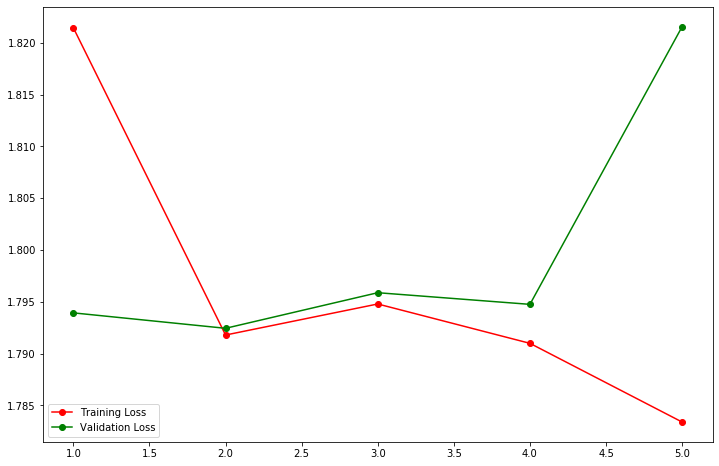

In [ ]:
# Making the plot larger
plt.figure(figsize=(12, 8))

loss = history.history['loss']                          # Loss on the training data
val_loss = history.history['val_loss']                  # Loss on the validation data
epochs = range(1,6)

plt.plot(epochs, loss, 'ro-', label='Training Loss')
plt.plot(epochs, val_loss, 'go-', label = 'Validation Loss')
plt.legend()

The plot says it all.

There is a *gradual decrease in both the training and validation loss*. Also, The difference between the training and validation loss is not very large, suggesting that our model is no longer overfitting the training data.

---

## Further processing of the data

Till now, for each video we extracted 200 frames. But the approach to extract these frames is not very appropriate. What was being done is that from each video, **200 contiguous frames (8 seconds)** were being extracted. We know that the human body performs these activities (running, boxing etc.) with a certain speed. Within one second, the human body does not make much of a movement. Therefore, we do not need to collect each and every frame for each second of video that we are capturing. A different approach could be used, where only a certain number of frames are extraced for each second. 

So, suppose we have a video with a time duration of 10 seconds. With our previous approach, we would have extracted 10x25 = 250 frames. Then, we would have selected 200 frames from the middle (leaving out 25 frames from front and back).  
But, with our new method, we would be extracting only a few frames per second (say 5). We would then have a total of 10x5 = 50 frames extracted. Also, we can still put a limit on the maximum number of frames that we want (say 40), then out of these 50 frames, 40 would be selected (from front, last or middle).

We can therefore see that the **size of the data got reduced buy a large factor** (in this example, by 5 times). This could be a great advantage for our model training as our model would now take less time to train. Also, since we have saved some time here, we can improve the model by making it deeper (adding more layers). The model can still learn patterns from the training data accurately because **the data that we removed was just redundant**.

The helper function `read_videos()` has the functionality to do this via a parameter called `required_fps`.

- For our model, we would set the value of `required_fps` to **5**.
- The range of normalized pixels has also been changed from [0, 1] to [-1, 1]. This is because the mean of the pixels would then be 0, which would *help the model converge faster*.

In [33]:
# Imports
import numpy as np
from keras.utils import to_categorical;
from utils import Videos

# An object of the class `Videos` to load the data in the required format
reader = Videos(target_size=(128, 128), 
                to_gray=True, 
                max_frames=40, 
                extract_frames='first', 
                required_fps=5, 
                normalize_pixels=(-1, 1))

In [34]:
# Reading training videos and one-hot encoding the training labels
X_train = reader.read_videos(train_files)
y_train = to_categorical(train_targets, num_classes=6)
print('Shape of training data:', X_train.shape)
print('Shape of training labels:', y_train.shape)

100%|██████████| 150/150 [01:31<00:00,  1.63it/s]


Shape of training data: (150, 40, 128, 128, 1)
Shape of training labels: (150, 6)


In [35]:
# Reading validation videos and one-hot encoding the validation labels
X_valid = reader.read_videos(valid_files)
y_valid = to_categorical(valid_targets, num_classes=6)
print('Shape of validation data:', X_valid.shape)
print('Shape of validation labels:', y_valid.shape)

100%|██████████| 49/49 [00:32<00:00,  1.50it/s]


Shape of validation data: (49, 40, 128, 128, 1)
Shape of validation labels: (49, 6)


In [36]:
y_valid[:]

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0.

In [37]:
# Reading testing videos and one-hot encoding the testing labels
X_test = reader.read_videos(test_files)
y_test = to_categorical(test_targets, num_classes=6)
print('Shape of testing data:', X_test.shape)
print('Shape of testing labels:', y_test.shape)

100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Shape of testing data: (100, 40, 128, 128, 1)
Shape of testing labels: (100, 6)


In [38]:
print(y_test)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0.

### Model - 3

This model has one more layer than the previous models, but it produces a deeper vector, thus better at enconding the content of the video than the previous models.

The dense layers at the end are not changed and are same as that of *Model-2*.

In [39]:
# Imports
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, BatchNormalization
from keras.layers.core import Dense, Dropout

# Using the Sequential Model
model = Sequential()

# Adding Alternate convolutional and pooling layers
model.add(Conv3D(filters=16, kernel_size=(5, 3, 3), strides=(1, 1, 1), padding='same', activation='relu', 
                 input_shape=X_train.shape[1:]))
model.add(MaxPooling3D(pool_size=2, strides=(2, 2, 2), padding='same'))

model.add(Conv3D(filters=64, kernel_size=(2, 3, 3), strides=(1, 1, 1), padding='valid', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=(2, 2, 2), padding='same'))

model.add(Conv3D(filters=256, kernel_size=(2, 3, 3), strides=(1, 1, 1), padding='valid', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=(2, 2, 2), padding='same'))

model.add(Conv3D(filters=1024, kernel_size=(2, 3, 3), strides=(1, 1, 1), padding='valid', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=(2, 2, 2), padding='same'))

# A global average pooling layer to get a 1-d vector
# The vector will have a depth (same as number of elements in the vector) of 1024
model.add(GlobalAveragePooling3D())

# Hidden layer
model.add(Dense(32, activation='relu'))

# Dropout Layer
model.add(Dropout(0.5))

# Output layer
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 40, 128, 128, 16)  736       
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 20, 64, 64, 16)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 19, 62, 62, 64)    18496     
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 10, 31, 31, 64)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 9, 29, 29, 256)    295168    
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 5, 15, 15, 256)    0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 4, 13, 13, 1024)  

### Training Model - 3

Training `Model-3` for 40 epochs on the training data and saving the weights of the model that performed the best on the validation data.

Also, the optimizer used is `NADAM` instead of `ADAM`.

In [ ]:
# Imports
from keras.callbacks import ModelCheckpoint

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

# Saving the model that performed the best on the validation set
checkpoint = ModelCheckpoint(filepath='Model_3.weights.best.hdf5', save_best_only=True, verbose=1)
1
# Training the model for 40 epochs
history = model.fit(X_train, y_train, batch_size=16, epochs=20, 
                    validation_data=(X_valid, y_valid), verbose=2, callbacks=[checkpoint])

Epoch 1/20
10/10 - 563s - loss: 0.5042 - accuracy: 0.8000 - val_loss: 0.1874 - val_accuracy: 0.9388

Epoch 00001: val_loss improved from inf to 0.18745, saving model to Model_3.weights.best.hdf5
Epoch 2/20
10/10 - 579s - loss: 0.3897 - accuracy: 0.8200 - val_loss: 0.2368 - val_accuracy: 0.8980

Epoch 00002: val_loss did not improve from 0.18745
Epoch 3/20
10/10 - 554s - loss: 0.4476 - accuracy: 0.8067 - val_loss: 0.2212 - val_accuracy: 0.9592

Epoch 00003: val_loss did not improve from 0.18745
Epoch 4/20
10/10 - 554s - loss: 0.2673 - accuracy: 0.8800 - val_loss: 0.4532 - val_accuracy: 0.7959

Epoch 00004: val_loss did not improve from 0.18745
Epoch 5/20
10/10 - 545s - loss: 0.4565 - accuracy: 0.7600 - val_loss: 0.2103 - val_accuracy: 0.9388

Epoch 00005: val_loss did not improve from 0.18745
Epoch 6/20
10/10 - 539s - loss: 0.3695 - accuracy: 0.8667 - val_loss: 0.2380 - val_accuracy: 0.8571

Epoch 00006: val_loss did not improve from 0.18745
Epoch 7/20
10/10 - 530s - loss: 0.3114 - accu

### Evaluating Model - 3

Evaluating `Model-3` on the test data.

In [40]:
# Loading the model that performed the best on the validation set
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.load_weights('Model_3.weights.best.hdf5')

# Testing the model on the Tes't data
(loss, accuracy) = model.evaluate(X_test, y_test, batch_size=16, verbose=0)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))

Accuracy on test data: 91.00%


In [ ]:
import tensorflow as tf
print("num",len(tf.config.experimental.list_logical_devices('GPU')))

num 0


In [22]:
model.load_weights('Model_3.weights.best.hdf5')
model.predict_classes(X_test)


OSError: ignored

## Model - 3 Performance

The model gave an **Accuracy of 64.5% on the test data**.

This time, the model gave a higher accuracy than the previous models, despite using 5 times lesser data for training.

### Learning Curve

ValueError: ignored

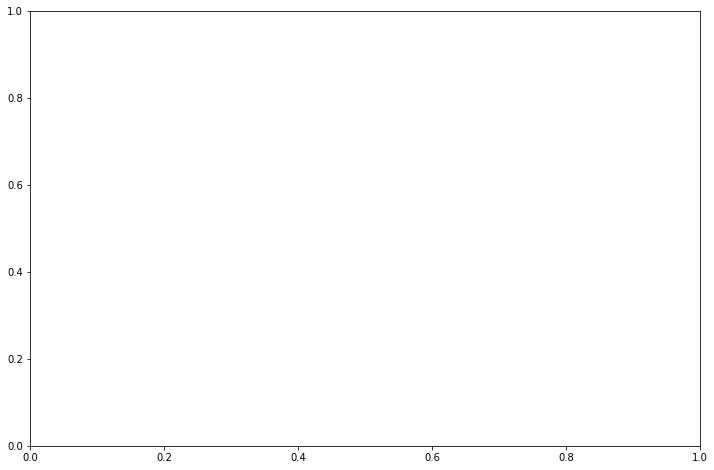

In [ ]:
# Making the plot larger
plt.figure(figsize=(12, 8))

loss = history.history['loss']                          # Loss on the training data
val_loss = history.history['val_loss']                  # Loss on the validation data
epochs = range(1, 13)

plt.plot(epochs, loss, 'ro-', label='Training Loss')
plt.plot(epochs, val_loss, 'go-', label = 'Validation Loss')
plt.legend()

From the learning curve, it is evident that the model did not overfit the data, and if it would have been trained more, the model could have performed better. The model gave an accuracy of 64.5% on the test data, which is the highest among the three models.

## Comparision with the Benchmark Model

Finally, we will compare our model (`Model-3`) with the benchmark model that we selected. **The benchmark model used a test data of 9 persons**. So, *we will select the videos of 9 persons (randomly) performing each of these actions*. We will then predict the outcomes of these videos using our model. In order to compare our model with the benchmark model, we would use the confusion matrix of these models.

    Note: 
    The instructions on the selection of these 9 persons was not available, therefore they have been selected randomly.

In [ ]:
# Imports
import numpy as np
np.random.seed(141)

# Choosing 9 random persons (unique)
people = np.arange(1, 26)
chosen = np.random.choice(people, 9, replace=False)

print('The following people are chosen:', chosen)

# Selecting the paths of all the videos of these persons from our entire dataset
bench_files = []
indexes = []
for index in chosen:
    for i, path in enumerate(raw_data['filenames']):
        if (('person' + str(index)) in path) or (('person0' + str(index)) in path):
            bench_files.append(path)
            indexes.append(i)
            
bench_files = np.array(bench_files)
bench_targets = raw_data['target'][indexes]
print(bench_files.shape)

### Reading in the data in the same format that was used before

In [ ]:
# Imports
import numpy as np
from keras.utils import to_categorical
from utils import Videos

# An object of the class `Videos` to load the data in the required format
reader = Videos(target_size=(128, 128), 
                to_gray=True, 
                max_frames=40, 
                extract_frames='first', 
                required_fps=5, 
                normalize_pixels=(-1, 1))

In [ ]:
bench_video = reader.read_videos(bench_files)
bench_target = to_categorical(bench_targets, num_classes=2)
print('Shape of training data:', bench_video.shape)
print('Shape of training labels:', bench_target.shape)

So, now we have 216 videos (24 videos for each of the 9 person). We will load our model and evaluate the performance of the model on this data.

In [ ]:
# Loading the model that performed the best on the validation set
model.load_weights('Model_3.weights.best.hdf5')

# Testing the model on the Test data
(loss, accuracy) = model.evaluate(bench_video, bench_target, batch_size=16, verbose=0)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))

The model gave an **accuracy of ~69%** on the data of 9 persons.

## The Benchmark Model

The following model is used as a benchmark - [Recognizing Human Actions: A Local SVM Approach](http://ftp.nada.kth.se/CVAP/users/laptev/icpr04actions.pdf)

Below is the confusion matrix obtained from this model:
![Benchmark Confusion Matrix](images/benchmark_result.PNG)

The confusion matrix has been normalized (the sum of each row is equal to 100).

- We would have modify the order of classes of the confusion matrix. 
- Also, we will get the values in range [0, 1] (by dividing by 100).  
This is done so as to *simplify the comparision of the confusion matrix with that of our model*.

In [ ]:
# Changed the sequence of the classes
benchmark_cnf_matrix = [
    [0.979, 0.07, 0.07, 0.0, 0.0, 0.07], 
    [0.354, 0.597, 0.035, 0.0, 0.0, 0.014], 
    [0.208, 0.049, 0.736, 0.0, 0.0, 0.07], 
    [0.0, 0.0, 0.0, 0.604, 0.167, 0.229], 
    [0.0, 0.0, 0.0, 0.389, 0.549, 0.063], 
    [0.0, 0.0, 0.0, 0.162, 0.0, 0.838]
]

benchmark_cnf_matrix = np.array(benchmark_cnf_matrix)

#### Below is a function for plotting the confusion matrix of the Benchmark model.
The code is taken from [here](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)

In [ ]:
import itertools
def confusion_matrix_plot(cm, classes, 
                          title='Normalized Confusion Matrix', 
                          normalize=False, 
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    plt.subplots(1, 1, figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Confusion Matrix of the Benchmark Model

In [ ]:
# Plotting the Confusion matrix of the Benchmark Model
confusion_matrix_plot(benchmark_cnf_matrix, 
                      classes=['boxing', 'handclapping', 'handwaving', 'jogging', 'running', 'walking'])

### Confusion matrix of our Model (`Model-3`)

In [ ]:
# Imports
from sklearn.metrics import confusion_matrix

# Getting the predictions of our Model
predictions = model.predict_classes(bench_video)

# Constructing the Confusion Matrix
model_cnf_matrix = confusion_matrix(bench_targets, predictions)

# PLotting the confusion matrix of our model
confusion_matrix_plot = confusion_matrix_plot(model_cnf_matrix, 
                                              classes=['boxing', 'handclapping', 'handwaving', 'jogging', 'running', 'walking'], 
                                              normalize=True)

---
## Problem with the Data

### The sequence of frames of a sample video of *Running*

In [ ]:
# Plotting the selected frames of a sample video (action being performed is running)

f, axarr = plt.subplots(5, 8, figsize=(17, 10))
row = 0
col = 0
for index, frame in enumerate(bench_video[17]):
    if index in [8, 16, 24, 32, 40]:
        row += 1
        col = 0
    axarr[row, col].imshow(np.squeeze(frame, axis=2), cmap='gray')
    col += 1

### The sequence of frames of a sample video of *Jogging*

In [ ]:
# Plotting the selected frames of a sample video (action being performed is jogging)

f, axarr = plt.subplots(5, 8, figsize=(17, 10))
row = 0
col = 0
for index, frame in enumerate(bench_video[13]):
    if index in [8, 16, 24, 32, 40]:
        row += 1
        col = 0
    axarr[row, col].imshow(np.squeeze(frame, axis=2), cmap='gray')
    col += 1

### The sequence of frames of a sample video of *Walking*

In [ ]:
# Plotting the selected frames of a sample video (action being performed is walking)

f, axarr = plt.subplots(5, 8, figsize=(17, 10))
row = 0
col = 0
for index, frame in enumerate(bench_video[21]):
    if index in [8, 16, 24, 32, 40]:
        row += 1
        col = 0
    axarr[row, col].imshow(np.squeeze(frame, axis=2), cmap='gray')
    col += 1